In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
from dsn.util.dsn_util import get_system_from_template, get_arch_from_template
from dsn.util.plot_util import plot_opt, dsn_pairplots, get_log_q_z_mesh
from dsn.util.dsn_util import get_savedir, load_DSNs
from tf_util.stat_util import approx_equal
from tf_util.tf_util import dgm_hessian, load_dgm, init_batch_norms
from dsn.util.dsn_util import load_DSN_fast
from dsn.util.plot_util import pairplot


import os
os.chdir('../../')

In [2]:
#Behavior params

omega = 1.0
d_std = 0.25
omega_std = 0.1

# Real NVP params
repeats = 1
nlayers = 2
sigma_init = 1.0


# Optimization params
c_init = -1
start_rs = 1
num_rs = 1

frac_samps = 0.2

sysname = "Linear2D"
param_dict = {'omega':omega,
              'd_std':d_std,
              'omega_std':omega_std}
system = get_system_from_template(sysname, param_dict)


arch_params = {
               'D':system.D,
               'repeats':repeats,
               'nlayers':nlayers,
               'sigma_init':sigma_init,
               'post_affine':True,
              }
param_dict.update(arch_params)
arch_dict = get_arch_from_template(system, param_dict)

rs = 1
dir_str = '2DLDS_test'

model_dirs = [get_savedir(system, arch_dict, c_init, rs, dir_str)]
ME_its = [8]



Loaded params from optimization.
0 [<tf.Tensor 'Const:0' shape=(1, 3032) dtype=float64>] [(1, 3032)]
j 0 theta_1_1
Instructions for updating:
Colocations handled automatically by placer.
params Tensor("DensityNetwork/Layer1/concat:0", shape=(1, 3032), dtype=float64)
0 Z Tensor("Placeholder:0", shape=(1, ?, 4), dtype=float64)
j 0 theta_2_1
post mult params Tensor("DensityNetwork/PostMultLayer/concat:0", shape=(1, 4), dtype=float64)
j 0 theta_3_1
post shift params Tensor("DensityNetwork/PostShiftLayer/concat:0", shape=(1, 4), dtype=float64)


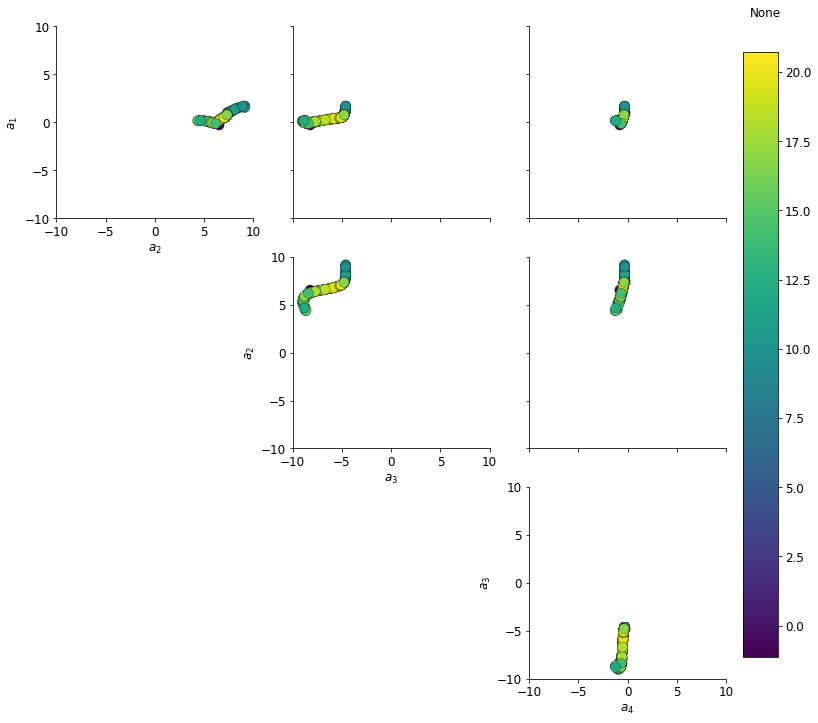

In [5]:
tf_vars, feed_dict = load_DSN_fast(system, arch_dict, model_dirs[0], ME_its[0])
M = 300
for i, model_dir in enumerate(model_dirs):
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_vars
    
    _W = np.random.normal(0.0, 1.0, (1,M,system.D))
    _Z_input_dummy = np.zeros((1,1,system.D))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        _Z_samp, _log_q_Z = sess.run([Z, log_q_Z], feed_dict)
    
    pairplot(_Z_samp[0], range(4), system.z_labels, c=_log_q_Z[0],
             xlims=[-10, 10], ylims=[-10, 10])


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/2DLDS_test/Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_6.25E-02_3.95E-01_flow=1R_4M_2L_15U_M_A_iso_std=1.0_sigma=1.00_c=-1_rs=1/model-8
Loaded DGM in 1.27 seconds
here 1


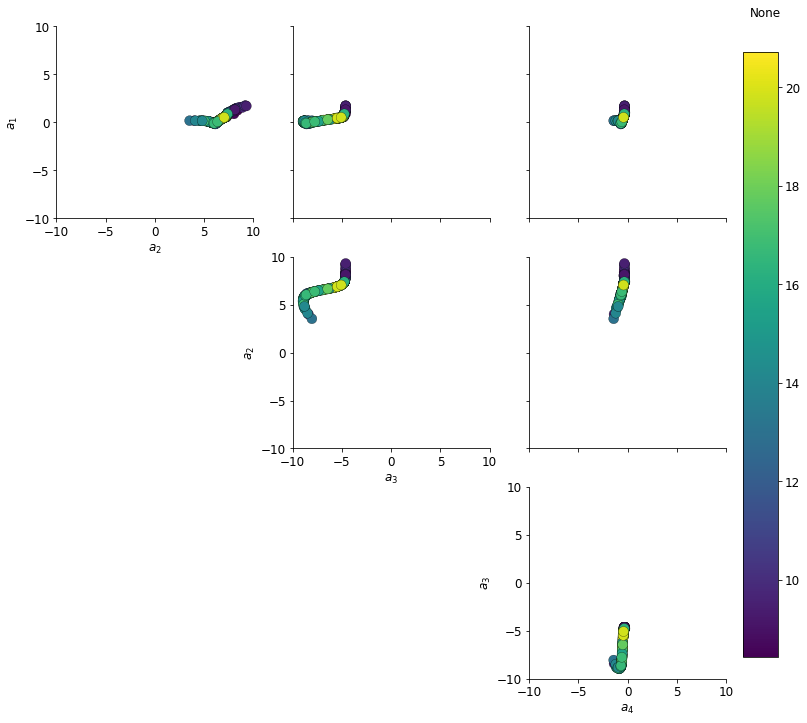

In [3]:
sessions, tf_vars, feed_dicts = load_DSNs(model_dirs, ME_its)
M = 300
for i, model_dir in enumerate(model_dirs):
    sess = sessions[i]
    tf_var = tf_vars[i]
    feed_dict = feed_dicts[i]
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
    
    _W = np.random.normal(0.0, 1.0, (1,M,system.D))
    _Z_input_dummy = np.zeros((1,1,system.D))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    _Z_samp, _log_q_Z = sess.run([Z, log_q_Z], feed_dict)
    
    pairplot(_Z_samp[0], range(4), system.z_labels, c=_log_q_Z[0],
             xlims=[-10, 10], ylims=[-10, 10])
